In [1]:
import numpy as np
import torch
import torch.optim as optim

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) 
t_u = torch.tensor(t_u).unsqueeze(1) 

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices


(tensor([9, 5, 4, 8, 3, 6, 7, 2, 0]), tensor([10,  1]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # Arguments = number of input features, number of output features, includes bias or not (default True)
linear_model(t_un_val)

tensor([[-5.5190],
        [-4.3853]], grad_fn=<AddmmBackward0>)

In [6]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[-0.9069]], requires_grad=True),
 Parameter containing:
 tensor([0.6845], requires_grad=True))

In [7]:
x = torch.ones(1)
linear_model(x)

tensor([-0.2225], grad_fn=<ViewBackward0>)

In [8]:
x = torch.ones(10, 1)
x, linear_model(x)

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([[-0.2225],
         [-0.2225],
         [-0.2225],
         [-0.2225],
         [-0.2225],
         [-0.2225],
         [-0.2225],
         [-0.2225],
         [-0.2225],
         [-0.2225]], grad_fn=<AddmmBackward0>))

In [9]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(), # instead of *params
    lr = 1e-2
)

In [10]:
linear_model.parameters()

<generator object Module.parameters at 0x000001EEA8BA14D0>

In [11]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.5799]], requires_grad=True),
 Parameter containing:
 tensor([-0.8941], requires_grad=True)]

In [12]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train) # here the model is not user defined but nn.Linear
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [13]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 278.5565, Validation loss 537.1743
Epoch 1000, Training loss 3.6057, Validation loss 5.5638
Epoch 2000, Training loss 2.9543, Validation loss 4.1084
Epoch 3000, Training loss 2.9416, Validation loss 3.9286

Parameter containing:
tensor([[5.2048]], requires_grad=True)
Parameter containing:
tensor([-16.8144], requires_grad=True)


In [14]:
seq_model = nn.Sequential(
    nn.Linear(1, 13), # 1 input in first layer which connects 13 hidden features
    nn.Tanh(), # hyperbolic tan activation function
    nn.Linear(13, 1) # 13 outputs of activation function layer converted to 1 output
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [15]:
# These are the tensors that the optimizer will get. Again, after we call model.backward(),
# all parameters are populated with their grad, and the optimizer then updates their values accordingly during the optimizer.step() call.

[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [17]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [18]:
# to create named modules

from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [20]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.3343], requires_grad=True)

In [21]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) 

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 164.5733, Validation loss 330.7520
Epoch 1000, Training loss 6.8754, Validation loss 6.0500
Epoch 2000, Training loss 3.8047, Validation loss 9.7947
Epoch 3000, Training loss 2.0521, Validation loss 6.1337
Epoch 4000, Training loss 1.5879, Validation loss 3.5896
Epoch 5000, Training loss 1.5321, Validation loss 3.6458
output tensor([[20.2885],
        [11.3951]], grad_fn=<AddmmBackward0>)
answer tensor([[21.],
        [14.]])
hidden tensor([[-0.0011],
        [-0.0015],
        [-0.0008],
        [-0.0048],
        [ 0.0010],
        [ 0.0134],
        [ 0.0153],
        [ 0.0285]])


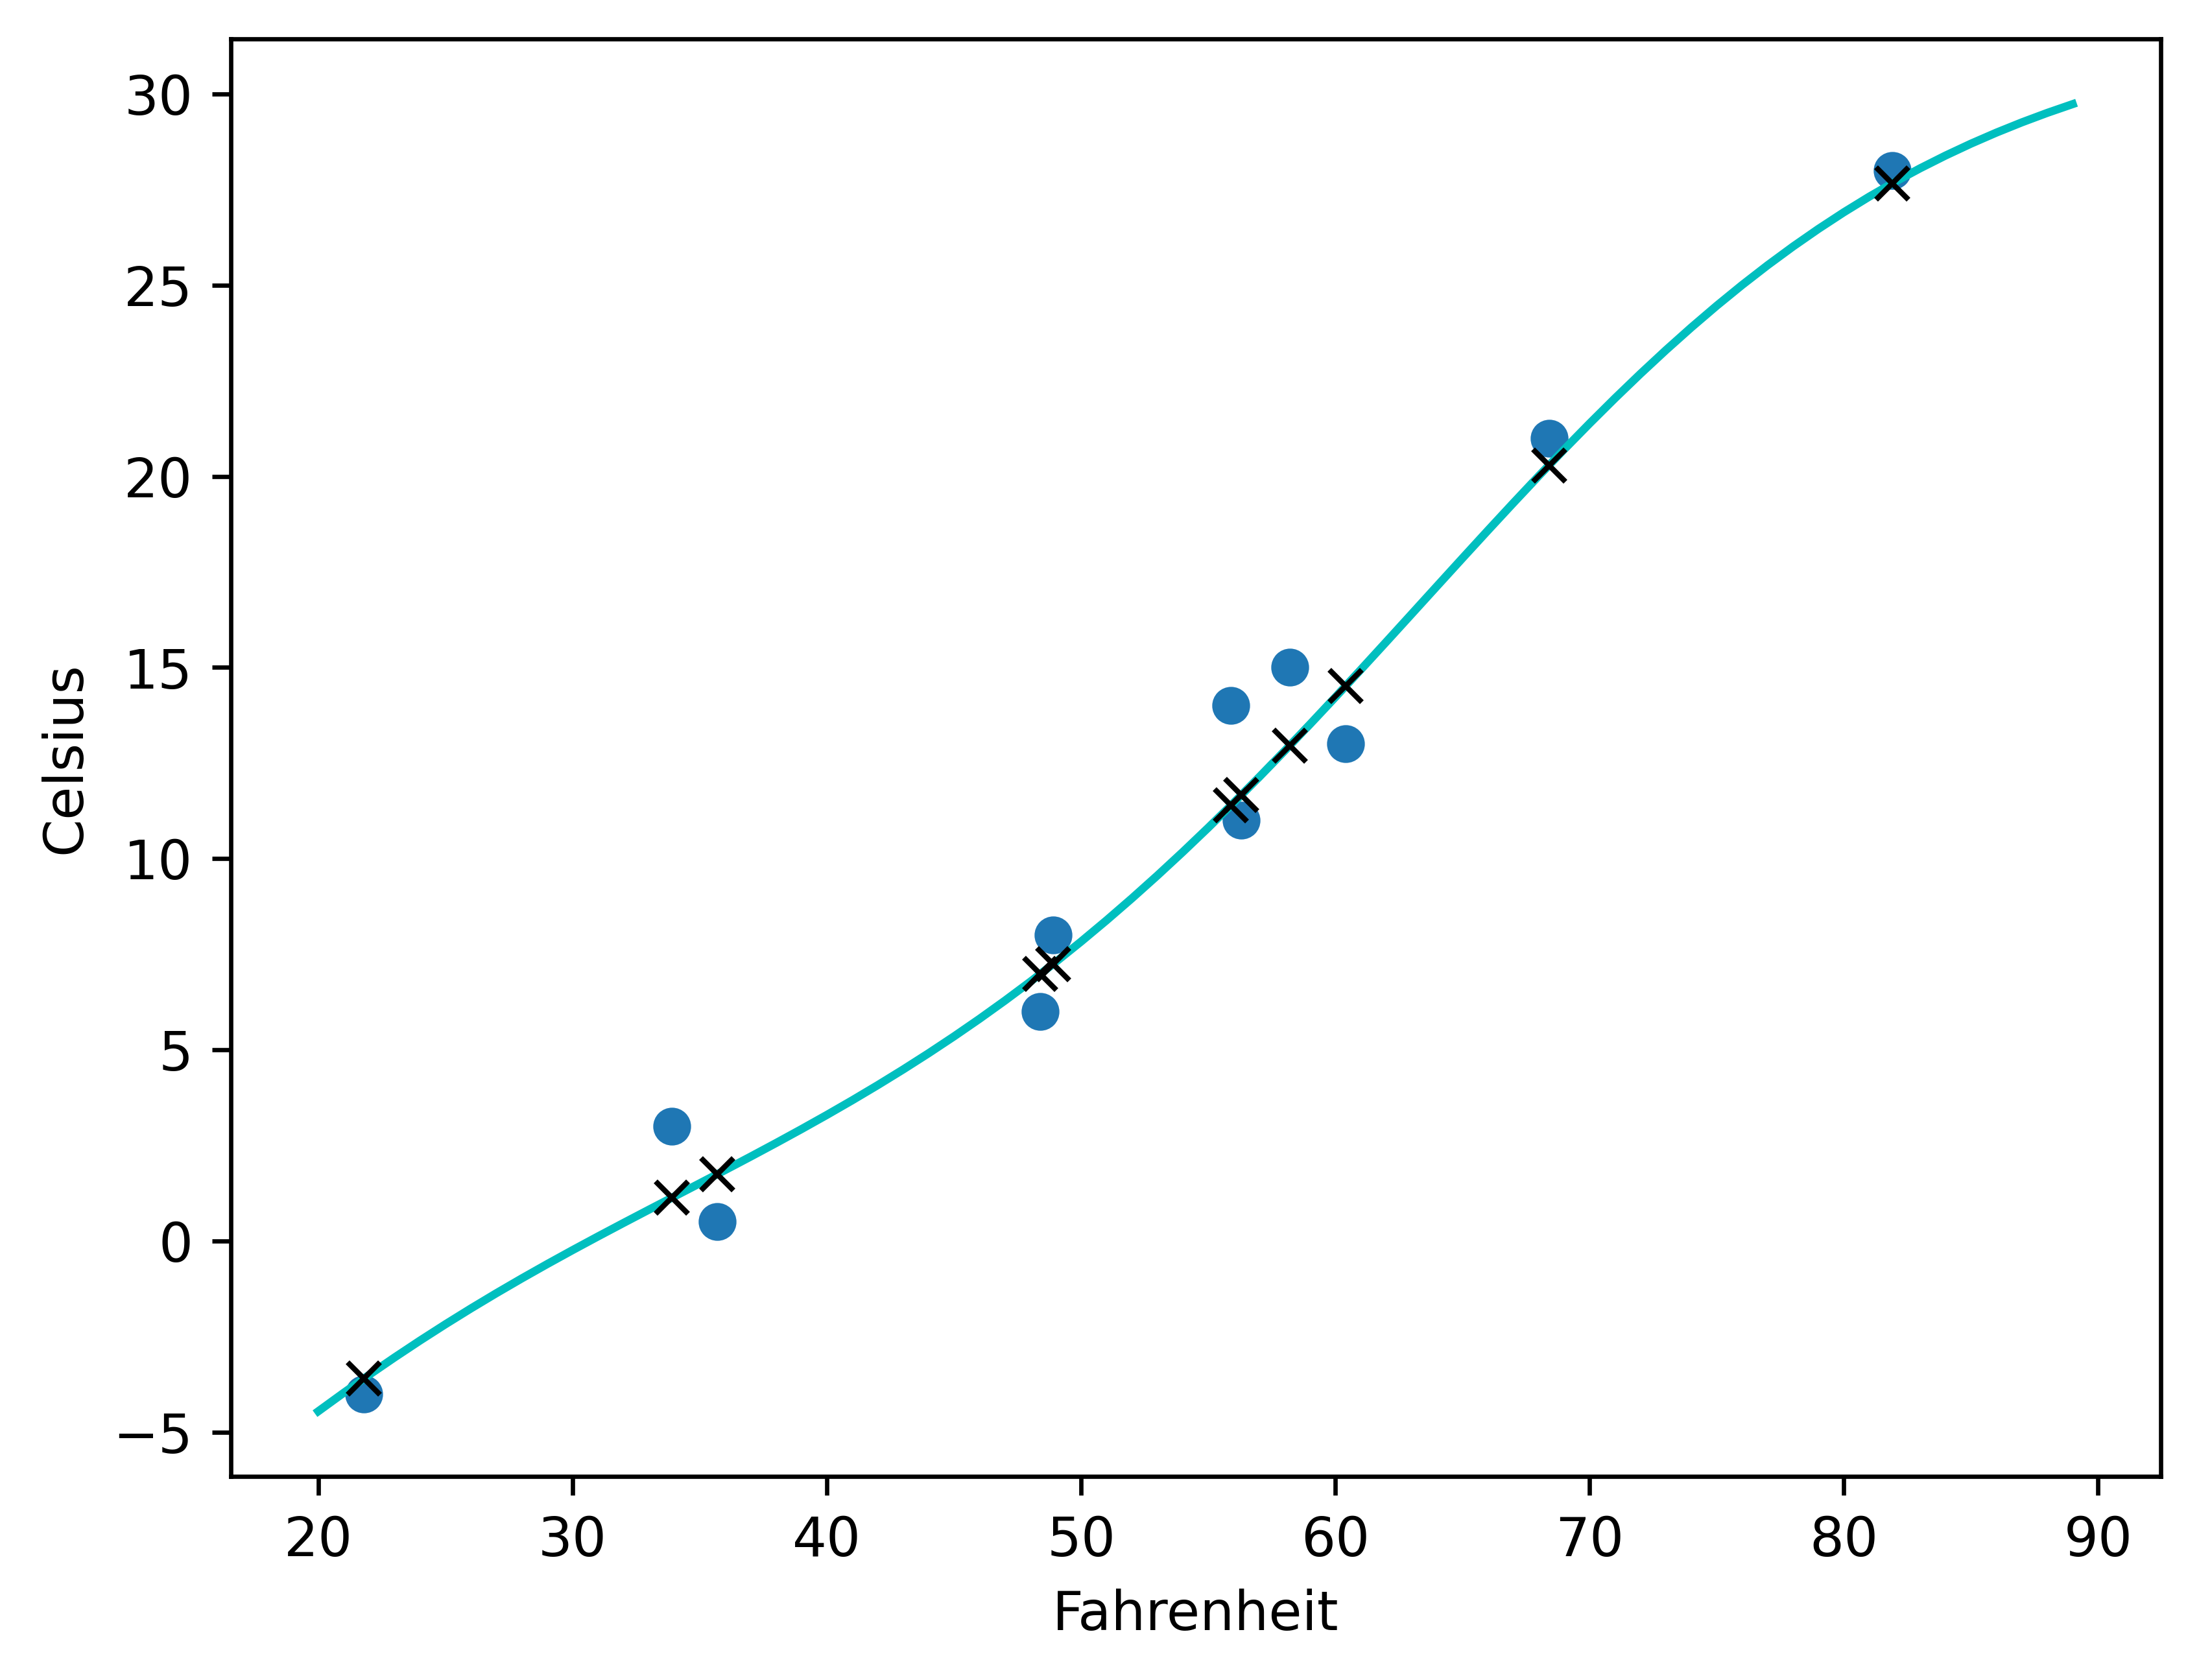

In [22]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')